<a href="https://www.kaggle.com/code/klimyuriy/notebook8e65578a69?scriptVersionId=192392783" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [11]:
import numpy as np
import pandas as pd
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [12]:
import torch
from torchvision import datasets, transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
data_dir = '/kaggle/input/fruit-recognition/train/train'

dataset = datasets.ImageFolder(root=data_dir)
len(dataset)

16854

In [14]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=100x100>, 0)

In [15]:
label = dataset[0]

In [16]:
from torch.utils.data import random_split

train_ratio = 0.8

train_data, val_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [17]:
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-180, 180), fill=(255, 255, 255)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.6401, 0.5461, 0.4808], std=[0.2752, 0.3295, 0.3695])
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.6401, 0.5461, 0.4808], std=[0.2752, 0.3295, 0.3695])
])


class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.classes = dataset.classes
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
train_data = TransformDataset(train_data, transform = train_transform)
val_data = TransformDataset(val_data, transform = test_transform)
dataset_tensor = TransformDataset(dataset, transform = test_transform)

len(train_data), len(val_data)

(13484, 3370)

In [18]:
# means = []
# stds = []
# for img, _ in val_data:
#     means.append(torch.mean(img, [1, 2]).tolist())
#     stds.append(torch.std(img, [1, 2]).tolist())

# mean = torch.mean(torch.tensor(means), [0])
# std = torch.mean(torch.tensor(stds), [0])

# mean, std

# (tensor([0.0156, 0.0146, 0.0067]), tensor([0.9972, 0.9987, 1.0029]))

In [19]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size)

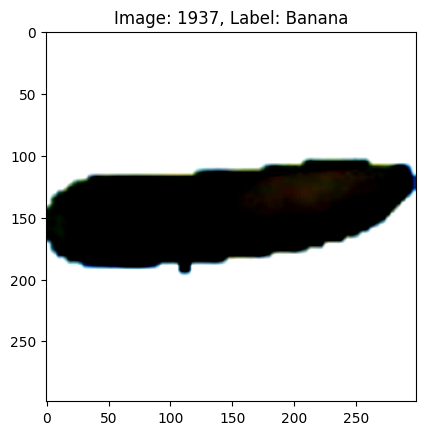

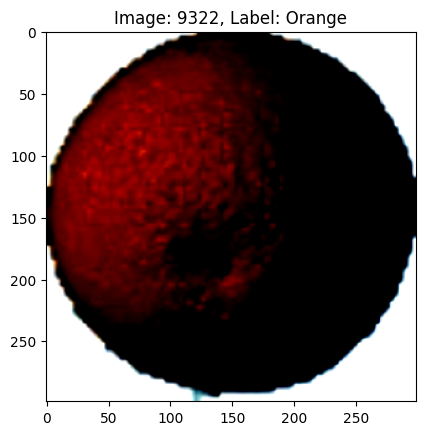

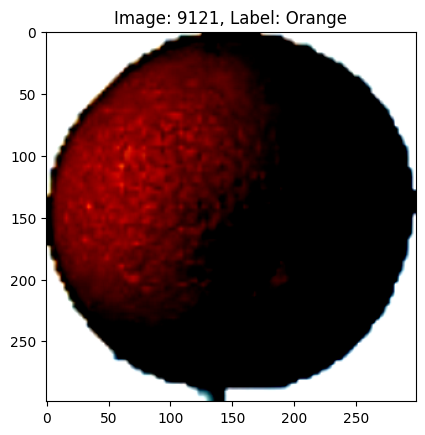

In [20]:
import matplotlib.pyplot as plt
import random

for _ in range(3):
    random_fruit = random.randint(0, 16853) 
    img, label = dataset_tensor[random_fruit]

    img = img.numpy()

    img = img.transpose((1, 2, 0))

    label_name = dataset.classes[label]

    plt.imshow(img)
    plt.title(f"Image: {random_fruit+1}, Label: {label_name}")
    plt.show()

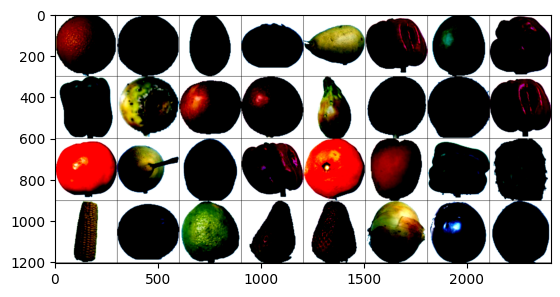

In [21]:
from torchvision.utils import make_grid

loader = torch.utils.data.DataLoader(dataset_tensor, shuffle=True, batch_size=32)
  
batch, labels = next(iter(loader))

grid = make_grid(batch).permute(1, 2, 0)

plt.imshow(grid)

In [22]:
from torchvision import models

inception = models.inception_v3(pretrained=True)
inception

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 162MB/s]  


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [23]:
import torch
import torch.nn.functional as F
import torch.nn as nn

class TransferLearningClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        inception = models.inception_v3(pretrained=True)

        for param in inception.parameters():
            param.requires_grad = False
        
        in_features = inception.fc.in_features

        inception.fc = nn.Identity()
        
        self.feature_extractor = inception
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        
        out = self.feature_extractor(x)
        if isinstance(out, tuple):
            out = out[0]
        
        out = self.dropout(out)
        out = self.linear(out)
        
        return out
    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()
    
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransferLearningClassifier(num_classes=len(dataset.classes)).to(device)

In [24]:
!pip install -q torchsummary

In [25]:
from torchsummary import summary

summary(model, input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [26]:
# from collections import defaultdict

# class_counts = defaultdict(int)
# for _, label in dataset:
#     class_counts[dataset.classes[label]] += 1
    
# for class_name, count in class_counts.items():
#     print(f'Клас {class_name}: {count} зображень')
    
# Клас Apple Braeburn: 492 зображень
# Клас Apple Granny Smith: 492 зображень
# Клас Apricot: 492 зображень
# Клас Avocado: 427 зображень
# Клас Banana: 490 зображень
# Клас Blueberry: 462 зображень
# Клас Cactus fruit: 490 зображень
# Клас Cantaloupe: 492 зображень
# Клас Cherry: 492 зображень
# Клас Clementine: 490 зображень
# Клас Corn: 450 зображень
# Клас Cucumber Ripe: 392 зображень
# Клас Grape Blue: 984 зображень
# Клас Kiwi: 466 зображень
# Клас Lemon: 492 зображень
# Клас Limes: 490 зображень
# Клас Mango: 490 зображень
# Клас Onion White: 438 зображень
# Клас Orange: 479 зображень
# Клас Papaya: 492 зображень
# Клас Passion Fruit: 490 зображень
# Клас Peach: 492 зображень
# Клас Pear: 696 зображень
# Клас Pepper Green: 444 зображень
# Клас Pepper Red: 666 зображень
# Клас Pineapple: 490 зображень
# Клас Plum: 447 зображень
# Клас Pomegranate: 492 зображень
# Клас Potato Red: 450 зображень
# Клас Raspberry: 490 зображень
# Клас Strawberry: 492 зображень
# Клас Tomato: 738 зображень
# Клас Watermelon: 475 зображень

In [27]:
# from collections import Counter

# class_counts = Counter()
# for _, label in dataset:
#     class_counts[label] += 1

# total_samples = sum(class_counts.values())
# class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# weights = torch.tensor([class_weights[i] for i in range(len(class_counts))], dtype=torch.float32).to(device)
# weights

In [28]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl, scheduler=None,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression', log_interval=1):
    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {}
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    model.to(device)

    start_time_train = time.time()

    for epoch in range(epochs):
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss'] + metrics_name}

        for batch in train_dl:
            x = batch[0].to(device)
            y = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    if func == roc_auc_score:
                        # Check if there are both classes present in y
                        if len(np.unique(y)) == 2:
                            history_train[name] += func(y, y_pred) * x.size(0)
                    else:
                        history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary':
                        y_pred_ = y_pred.round()
                    elif task == 'multiclass':
                        y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)

        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name + ['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x = batch[0].to(device)
                y = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        if func == roc_auc_score:
                            # Check if there are both classes present in y
                            if len(np.unique(y)) == 2:
                                history_val['val_' + name] += func(y, y_pred) * x.size(0)
                        else:
                            history_val['val_' + name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary':
                            y_pred_ = y_pred.round()
                        elif task == 'multiclass':
                            y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_' + name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_' + name].append(history_val['val_' + name])

        total_time_epoch = end_time_epoch - start_time_epoch

        if epoch + 1 == 1 or (epoch + 1) % log_interval == 0 or epoch + 1 == epochs:
            print(f'Epoch {epoch + 1:4d} {total_time_epoch:4.0f}sec', end='\t')
            for name in history_train:
                print(f'{name}: {history[name][-1]:10.3g}', end='\t')
                print(f"val_{name}: {history['val_' + name][-1]:10.3g}", end='\t')
            print()

        if scheduler:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(history_val['val_loss'][-1])
            else:
                scheduler.step()

    end_time_train = time.time()
    total_time_train = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [30]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, val_loader,
                epochs=20,
                metrics=[accuracy_score],
                device=device,
                task='multiclass',
               log_interval=1)

Epoch    1  148sec	loss:       1.22	val_loss:       0.62	accuracy_score:      0.791	val_accuracy_score:      0.963	
Epoch    2  110sec	loss:      0.332	val_loss:      0.341	accuracy_score:      0.949	val_accuracy_score:      0.966	
Epoch    3  112sec	loss:       0.21	val_loss:      0.235	accuracy_score:      0.963	val_accuracy_score:       0.98	
Epoch    4  110sec	loss:      0.163	val_loss:      0.188	accuracy_score:      0.969	val_accuracy_score:      0.983	
Epoch    5  109sec	loss:      0.133	val_loss:      0.142	accuracy_score:      0.973	val_accuracy_score:      0.985	
Epoch    6  110sec	loss:      0.119	val_loss:      0.127	accuracy_score:      0.975	val_accuracy_score:      0.985	
Epoch    7  109sec	loss:      0.104	val_loss:      0.101	accuracy_score:      0.976	val_accuracy_score:       0.99	
Epoch    8  109sec	loss:     0.0987	val_loss:     0.0944	accuracy_score:      0.976	val_accuracy_score:      0.989	
Epoch    9  109sec	loss:     0.0883	val_loss:     0.0772	accuracy_score:

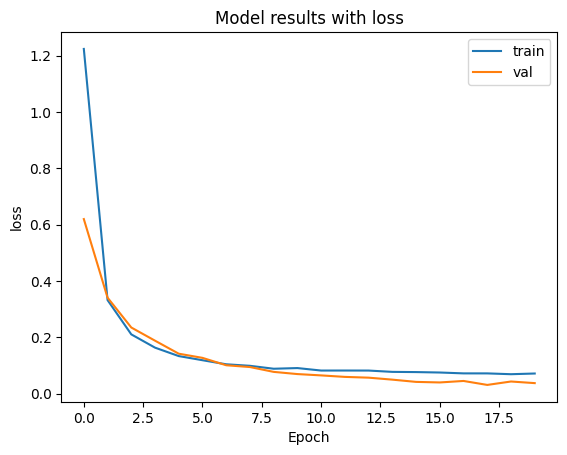

In [31]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

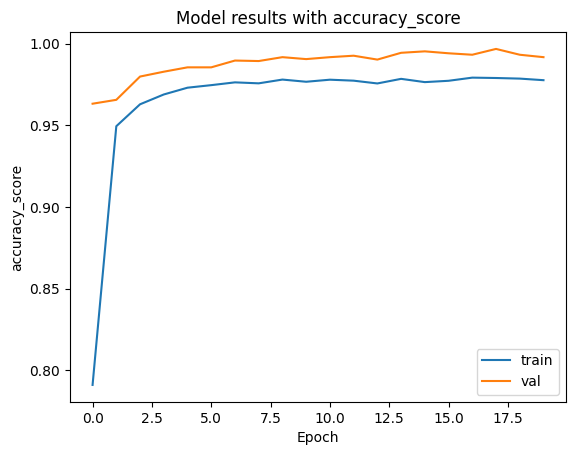

In [32]:
plot_metric(history, 'accuracy_score')

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')

loader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1), display_labels=dataset.classes, ax=ax)
plt.xticks(rotation=90)
plt.show()

# **Передбачення на власних фото**

In [ ]:
import requests
from PIL import Image
from io import BytesIO

def load_and_predict(url, model, transform, device='cpu'):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.show()

    image = transform(image).unsqueeze(0)

    model = model.to(device)
    image = image.to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        prediction = output.argmax(dim=1).item()

    class_name = dataset.classes[prediction]
    
    return class_name

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor()
])

url = 'https://img.freepik.com/premium-photo/one-corn-maize-cobs-white-surface_406939-1408.jpg'
predicted_class = load_and_predict(url, model, transform, device=device)
print(predicted_class)